# Synthetic test of the STF estimation

This notebook performs the synthetic test of the estimation in the source time function.

- 2025.1.29 Kurama Okubo

In [1]:
import os
# import obspy
# from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
from scipy.optimize import minimize
from scipy import integrate 

# from obspy.signal.cross_correlation import correlate, xcorr_max

# from obspy.core.utcdatetime import UTCDateTime    

from synthetic_STFfittest import *

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
# UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


# Prcess flow

We evaluate the performance of STF estimation considering the water level of Q deconvolution and band-pass filter.

1. Synthesize the true source time function
2. Convolve Q to the true STF. This should be equivalent to the observation.
3. apply bandpass filter
4. deconvolve Q with the water-level
5. Compare the true and estimated source parameters.

## 1. Synthesize the true STF

In [2]:
M0_try = 0.5
TR_try = 2.6e-6
dt = 1e-9
stf_type = "cosine"

#1. compute stf
tvec_syn = np.linspace(0, TR_try, int(TR_try/dt))

STF_syn = stf_cosine(tvec_syn, TR_try, M0_try)

In [3]:
twin_margin = 8e-6 #10e-6 #3e-6

STF_long = np.zeros(len(tvec_syn)+2*int(twin_margin/dt))
STF_long[int(twin_margin/dt):int(twin_margin/dt)+len(tvec_syn)] = STF_syn

tvec_long = -twin_margin + np.arange(0, len(STF_long)) * dt

In [4]:
# align data length to be even number
if np.mod(len(tvec_long), 2) != 0:
    tvec_long = tvec_long[:-1]
    STF_long = STF_long[:-1]

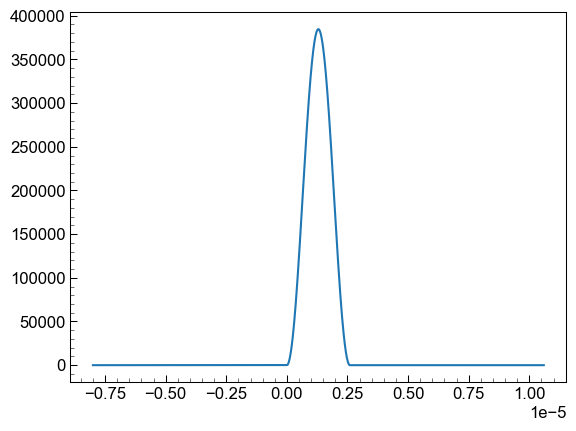

In [5]:
plt.plot(tvec_long, STF_long)

## 2. Convolve Q

$$y(\omega) = s(\omega)G(\omega; \mathbf{x})  B(\omega), $$
where

$$ B(\omega) =\exp{\left( - \dfrac{\omega t}{2 Q(\omega)} \right) } .$$


In [6]:
Qinv_quart = 50

In [7]:
# Read Q model
df_Qinv_quantile = pd.read_csv("../../../Calibration/Attenuation/data/df_Qinv_quantile.csv", index_col=0)
df_Qinv_quantile.head()

,freq,Qinv_25,Qinv_50,Qinv_75
0,0.039062,0.013403,0.036839,0.048583
1,0.078125,0.009528,0.018667,0.036067
2,0.117188,0.007164,0.016207,0.023822
3,0.156250,0.004907,0.010891,0.017656
4,0.195312,0.004253,0.008820,0.014757


In [8]:
# parameters of deconvolution
Ndata_FFT = len(tvec_long)
# NFFT = 2**(Ndata-1).bit_length()
NFFT = Ndata_FFT # same length of the data for the sake of simplicity

print(Ndata_FFT, NFFT)

18598 18598


In [9]:
df_Qinv_quantile.head()

,freq,Qinv_25,Qinv_50,Qinv_75
0,0.039062,0.013403,0.036839,0.048583
1,0.078125,0.009528,0.018667,0.036067
2,0.117188,0.007164,0.016207,0.023822
3,0.156250,0.004907,0.010891,0.017656
4,0.195312,0.004253,0.008820,0.014757


Text(0, 0.5, 'Attenuation, $Q^{-1}$')

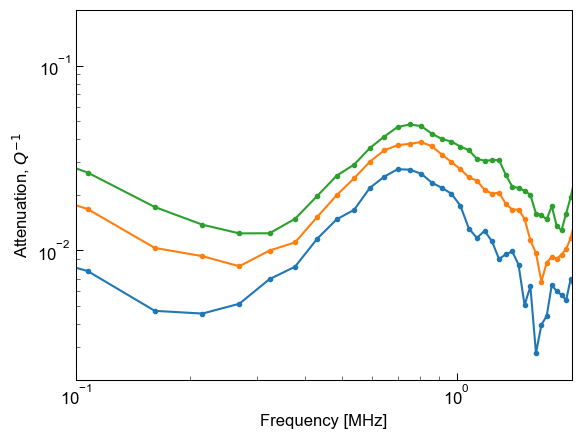

In [10]:
# Read the Qinv
F_freq = np.fft.rfftfreq(NFFT, d=dt)

for iq in [25, 50, 75]:
    Qinv = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{iq}"].values).astype(complex)
    plt.loglog(F_freq/1e6, Qinv.real, ".-")
    
plt.xlim([0.1, 2])
plt.ylim([0.002, 0.2])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Attenuation, $Q^{-1}$")


In [11]:
# Compute B(ω)
Qinv_interp = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{Qinv_quart}"].values).astype(float)

vp = 6200
source_dist = 120e-3 # source distance from source to the AE sensor
k_waterlevel = 0.3

tt = source_dist/vp
Bomega_interp = np.exp(-np.pi * F_freq * tt * Qinv_interp)
Bomega_wlv = np.maximum(np.abs(Bomega_interp), (k_waterlevel*np.abs(Bomega_interp).max()))


Text(0, 0.5, '$B(\\omega)$')

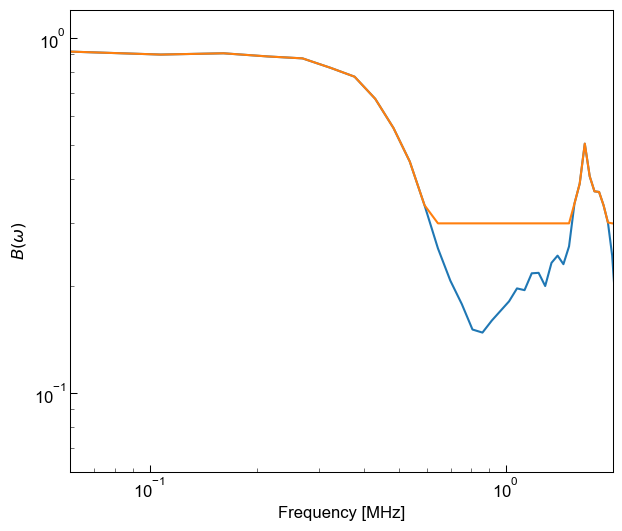

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.loglog(F_freq/1e6, Bomega_interp)
ax.loglog(F_freq/1e6, Bomega_wlv)
ax.set_xlim([0.06, 2])
ax.set_ylim([0.06, 1.2])
ax.set_xlabel(r"Frequency [MHz]")
ax.set_ylabel(r"$B(\omega)$")

In [13]:
# convolve the Bomega

F_obs = np.fft.rfft(STF_long, n=NFFT)
STF_long_Qconvolved = np.fft.irfft(F_obs*Bomega_interp).real # convolve the B omega to mimic the path effect


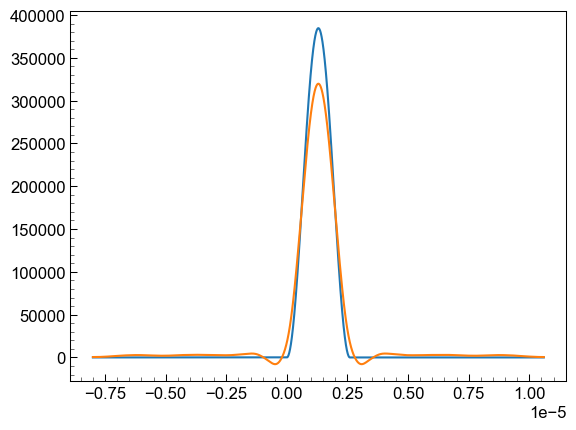

In [14]:
plt.plot(tvec_long, STF_long)
plt.plot(tvec_long, STF_long_Qconvolved)

## 3. Apply bandpass-filter

We apply high-pass filter same as the main analysis.

In [15]:
# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.1e6 #
freqmax = 1e6 # 

butterworth_order = 3

# b, a = signal.butter(butterworth_order, (freqmin, freqmax), 'bandpass', fs=(1/dt), output='ba') # not work for upsampled dt
b, a = signal.butter(butterworth_order, (freqmin, ), 'highpass', fs=(1/dt), output='ba') #


In [16]:
STF_long_Qconvolved_tapered = STF_long_Qconvolved * signal.windows.tukey(Ndata_FFT, alpha=0.05)
STF_long_Qconvolved_filtered = signal.filtfilt(b, a, STF_long_Qconvolved_tapered, method='gust') # using two-way filter Gustafsson’s method


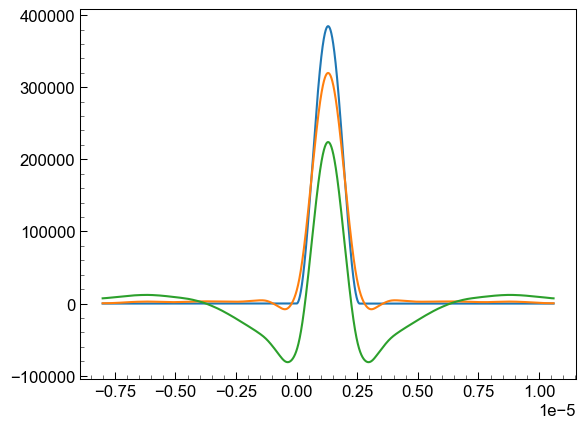

In [17]:
plt.plot(tvec_long, STF_long)
plt.plot(tvec_long, STF_long_Qconvolved)
plt.plot(tvec_long, STF_long_Qconvolved_filtered)


## 4. Deconvolve Q with water-level

In [18]:
F_obs_decon = np.fft.rfft(STF_long_Qconvolved_filtered, n=NFFT)
STF_long_Qdeconvolved = np.fft.irfft(F_obs_decon/Bomega_wlv).real # convolve the B omega to mimic the path effect


### 4.1 Remove the offset by left bottom amplitude

In [19]:
# 1. compute the slope before the pick

# pick the LBA as it is
STF_grad = np.gradient(STF_long_Qdeconvolved)

# https://stackoverflow.com/a/3843124
zero_crossings = np.where(np.diff(np.sign(STF_grad)) > 0)[0]

# min_list = zero_crossings
min_list = []

# remove if the amplitude of peak is greater than the threshold
for zeroid in zero_crossings:
    # print(tr_Pdisp_updampled_data_forLBApick[zeroid] , LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick))
    # if tr_Pdisp_updampled_data_forLBApick[zeroid] < LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick):
    min_list.append(zeroid)

min_list = np.array(min_list)

LBA_buffer_winlen = 1.0e-6 # standard value for the LBA buffer
    

In [20]:
zero_crossings

array([ 1525,  7939, 10657, 17068])

In [21]:
LBA_ind = min_list[np.where(int((twin_margin+LBA_buffer_winlen)/dt) - min_list > 0)[0][-1]] # search the first bump of STF; 1.2us as buffer of search window
LBA_amp = STF_long_Qdeconvolved[LBA_ind]
LBA_t = tvec_long[LBA_ind]
LBA_amp, LBA_t

(-88836.68013204625, -6.099999999999992e-08)

In [22]:
STF_long_Qdeconvolved_offsetremoved = STF_long_Qdeconvolved-LBA_amp

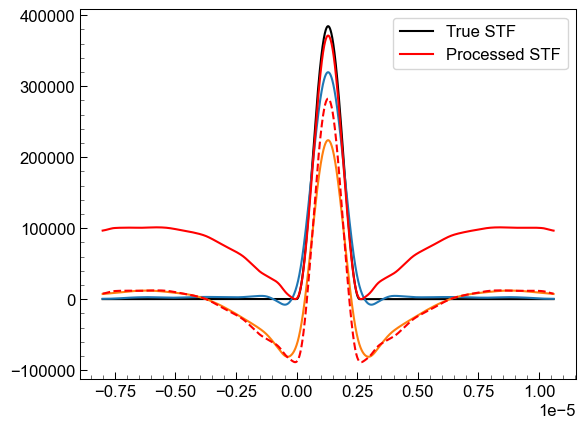

In [23]:
plt.plot(tvec_long, STF_long, "k", label="True STF")
plt.plot(tvec_long, STF_long_Qconvolved)
plt.plot(tvec_long, STF_long_Qconvolved_filtered)
plt.plot(tvec_long, STF_long_Qdeconvolved, "r--")
plt.plot(tvec_long, STF_long_Qdeconvolved_offsetremoved, "r-", label="Processed STF")
plt.legend()

In [24]:
# store for the master plot
masterSTF = {"t":tvec_long,
            "STF":STF_long,
            "STF_Qconvolved":STF_long_Qconvolved,
            "STF_Qdeconvolved":STF_long_Qdeconvolved_offsetremoved,
            "source_dist":source_dist,
            "M0_try":M0_try,
            "TR_try":TR_try,}

Here we confirmed that the STF is successfully recovered for this true model.

## 5. Fit the STF to estimate source parameters

In [25]:
Tshift_init = 0.0
pwin_pre = twin_margin

bounds = [(0, 10), (1.0e-6, 10.0e-6), (-0.5e-6, 1e-6)]
stf_type = "cosine" #"kupper" #"cosine"
xatol = 1e-8 #1e-8 #2 
fatol = 1e-8 #1e-8 #2

residu_win = [0.5, 0.25]

In [26]:
TR_init = 2.6e-6
M0_init = 0.5*np.max(STF_long_Qdeconvolved_offsetremoved)*TR_init
Tshift_init = 0.0
x0 = [M0_init, TR_init, Tshift_init]

In [27]:
len(STF_long_Qdeconvolved)

18598

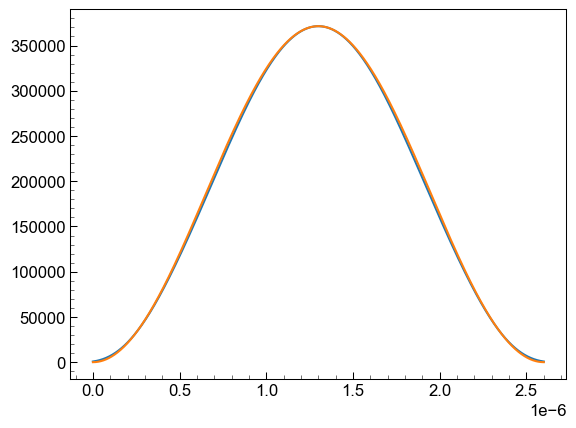

In [28]:
rmse, tvec_syn, STF_sensor, STF_syn = compute_res(x0, STF_long_Qdeconvolved_offsetremoved, dt,  pwin_pre, residu_win=[0.5, 0.5], stf_type="cosine", debug=1)


plt.plot(tvec_syn, STF_sensor)
plt.plot(tvec_syn, STF_syn)

In [29]:
res = minimize(compute_res, x0, args=(STF_long_Qdeconvolved_offsetremoved, dt, pwin_pre, residu_win, stf_type, False), 
               method='Nelder-Mead', bounds=bounds, options={"return_all": False, "xatol":xatol, "fatol":fatol, "maxfev":1000})


In [30]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1397.769061895347
             x: [ 4.773e-01  2.579e-06  9.437e-09]
           nit: 78
          nfev: 155
 final_simplex: (array([[ 4.773e-01,  2.579e-06,  9.437e-09],
                       [ 4.773e-01,  2.579e-06,  9.437e-09],
                       [ 4.773e-01,  2.579e-06,  9.437e-09],
                       [ 4.773e-01,  2.579e-06,  9.437e-09]]), array([ 1.398e+03,  1.398e+03,  1.398e+03,  1.398e+03]))

In [31]:
# synthesize the estimated STF
M0_best, Tw_best, tshift_best = res.x
print(Tw_best*1e6)
tvec_syn = np.linspace(0, Tw_best, int(Tw_best/dt))
STF_syn = stf_cosine(tvec_syn, Tw_best, M0_best)


2.578786088887651


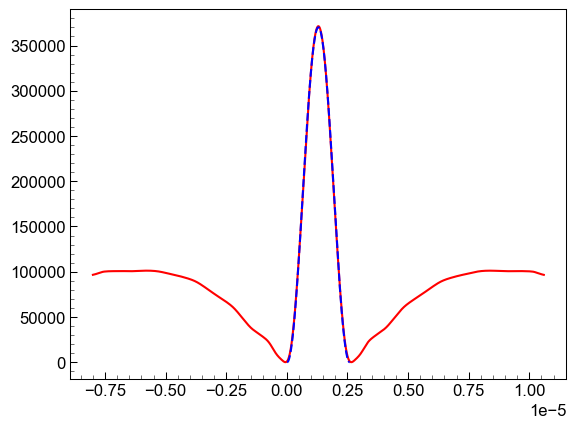

In [32]:
plt.plot(tvec_long, STF_long_Qdeconvolved_offsetremoved, "r-", label="Processed STF")
plt.plot(tvec_syn+tshift_best, STF_syn, "b--")


# Case study for variable $T_w$

We investigate the recovery of the source parameters after the deconvolution of attenuation factor.
We conduct the casestudy on the source duration and the source distance associated with the four AE sensor

In [33]:
df_events = pd.read_csv("../../../SourceInvFit/data/datacsv/AEevents_isocoord.csv", index_col=0)

In [34]:
df_events

AEsensor_list = ["OL23", "OL07", "OL08", "OL22"]
sourcedist_list = []
for stnm in AEsensor_list:
    sourcedist_list.append(df_events[df_events["OL"]==stnm]["rlen_sourcedist"].mean())

In [35]:
sourcedist_list

[0.09620965999999999,
 0.1203474715909091,
 0.1846125981818182,
 0.22835818068181818]

In [36]:
Tw_true_list = np.linspace(1.0, 4, 21) * 1e-6
M0_true = 1.0 #[Nm]

In [37]:
# Reset parameters
dt = 1e-9
stf_type = "cosine"
twin_margin = 8e-6 #10e-6 #3e-6
Qinv_quart = 50

vp = 6200
# source_dist = 180e-3 # source distance from source to the AE sensor
k_waterlevel = 0.3

freqmin = 0.1e6 #
freqmax = 1e6 # 

butterworth_order = 3

LBA_buffer_winlen = 1.0e-6 # standard value for the LBA buffer


Tshift_init = 0.0
pwin_pre = twin_margin

bounds = [(0, 10), (0.1e-6, 10.0e-6), (-0.5e-6, 1e-6)]
stf_type = "cosine" #"kupper" #"cosine"
xatol = 1e-2 #1e-8 #2 
fatol = 1e-2 #1e-8 #2

residu_win = [0.5, 0.25]

# TR_init = 2.6e-6 # fix Tw init

In [38]:
df_case = pd.DataFrame(columns=["source_dist", "M0_true", "Tw_true", "M0_est", "Tw_est", "tshift_fit"])
df_case

for sourcedist_case in sourcedist_list:
    for TR_try in tqdm(Tw_true_list):
        
        # TR_try = Tw_true_list[6]
        #1. Compute stf
        tvec_syn = np.linspace(0, TR_try, int(TR_try/dt))
        STF_syn = stf_cosine(tvec_syn, TR_try, M0_true)
        
        STF_long = np.zeros(len(tvec_syn)+2*int(twin_margin/dt))
        STF_long[int(twin_margin/dt):int(twin_margin/dt)+len(tvec_syn)] = STF_syn
        tvec_long = -twin_margin + np.arange(0, len(STF_long)) * dt
        
        # align data length to be even number
        if np.mod(len(tvec_long), 2) != 0:
            tvec_long = tvec_long[:-1]
            STF_long = STF_long[:-1]
        
        # parameters of deconvolution
        Ndata_FFT = len(tvec_long)
        NFFT = Ndata_FFT # same length of the data for the sake of simplicity
        
        # Read the Qinv
        F_freq = np.fft.rfftfreq(NFFT, d=dt)
        
        # Compute B(ω)
        Qinv_interp = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{Qinv_quart}"].values).astype(float)
        # tt = source_dist/vp
        tt = sourcedist_case/vp
        Bomega_interp = np.exp(-np.pi * F_freq * tt * Qinv_interp)
        Bomega_wlv = np.maximum(np.abs(Bomega_interp), (k_waterlevel*np.abs(Bomega_interp).max()))
        
        # convolve the Bomega
        
        F_obs = np.fft.rfft(STF_long, n=NFFT)
        STF_long_Qconvolved = np.fft.irfft(F_obs*Bomega_interp).real # convolve the B omega to mimic the path effect
        
        # ## 3. Apply bandpass-filter
        
        b, a = signal.butter(butterworth_order, (freqmin, ), 'highpass', fs=(1/dt), output='ba') #
        
        STF_long_Qconvolved_tapered = STF_long_Qconvolved * signal.windows.tukey(Ndata_FFT, alpha=0.05)
        STF_long_Qconvolved_filtered = signal.filtfilt(b, a, STF_long_Qconvolved_tapered, method='gust') # using two-way filter Gustafsson’s method
        
        # ## 4. Deconvolve Q with water-level
        
        F_obs_decon = np.fft.rfft(STF_long_Qconvolved_filtered, n=NFFT)
        STF_long_Qdeconvolved = np.fft.irfft(F_obs_decon/Bomega_wlv).real # convolve the B omega to mimic the path effect
        
        # 1. compute the slope before the pick
        
        # pick the LBA as it is
        STF_grad = np.gradient(STF_long_Qdeconvolved)
        
        # https://stackoverflow.com/a/3843124
        zero_crossings = np.where(np.diff(np.sign(STF_grad)) > 0)[0]
        
        # min_list = zero_crossings
        min_list = []
        
        # remove if the amplitude of peak is greater than the threshold
        for zeroid in zero_crossings:
            # print(tr_Pdisp_updampled_data_forLBApick[zeroid] , LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick))
            # if tr_Pdisp_updampled_data_forLBApick[zeroid] < LBA_thresh_zerocross_ampfactor * np.max(tr_Pdisp_updampled_data_forLBApick):
            min_list.append(zeroid)
        
        min_list = np.array(min_list)
        
        LBA_ind = min_list[np.where(int((twin_margin+LBA_buffer_winlen)/dt) - min_list > 0)[0][-1]] # search the first bump of STF; 1.2us as buffer of search window
        LBA_amp = STF_long_Qdeconvolved[LBA_ind]
        LBA_t = tvec_long[LBA_ind]
        
        STF_long_Qdeconvolved_offsetremoved = STF_long_Qdeconvolved-LBA_amp
        
        # ## 5. Fit the STF to estimate source parameters        
        # compute TR_init as the HMPW
        pmax = np.max(STF_long_Qdeconvolved_offsetremoved)
        pmax_ind = np.argmax(STF_long_Qdeconvolved_offsetremoved)
        
        halfamp = pmax/2
        
        # search the half pulse width
        halfamp_list = np.where(np.diff(np.sign(STF_long_Qdeconvolved_offsetremoved - halfamp)))[0]
        
        # for tiny events, skip if we cannot find the LHA or RHA due to low S/N
        LHA_ind = halfamp_list[np.where(halfamp_list - pmax_ind < 0)[0][-1]]
        RHA_ind = halfamp_list[np.where(halfamp_list - pmax_ind > 0)[0][0]] # set HMPW just below the half-maximum amplitude
        HMPW = tvec_long[RHA_ind] - tvec_long[LHA_ind]
        TR_init = 2*HMPW
        # print(TR_try, TR_init)
                
        M0_init = 0.5*np.max(STF_long_Qdeconvolved_offsetremoved)*TR_init
        Tshift_init = 0.0
        
        x0 = [M0_init, TR_init, Tshift_init]
        
        res = minimize(compute_res, x0, args=(STF_long_Qdeconvolved_offsetremoved, dt, pwin_pre, residu_win, stf_type, False), 
                       method='Nelder-Mead', bounds=bounds, options={"return_all": False, "xatol":xatol, "fatol":fatol, "maxfev":1000})
        
        
        # synthesize the estimated STF
        M0_best, Tw_best, tshift_best = res.x
        # print(Tw_best*1e6)
        tvec_syn = np.linspace(0, Tw_best, int(Tw_best/dt))
        STF_syn = stf_cosine(tvec_syn, Tw_best, M0_best)
        
        # # debug plot
        # plt.plot(tvec_long, STF_long_Qdeconvolved_offsetremoved, "r-", label="Processed STF")
        # plt.plot(tvec_syn+tshift_best, STF_syn, "b--")
        # plt.plot([tvec_long[LHA_ind], tvec_long[RHA_ind]], [halfamp, halfamp], "o")
        # print(TR_try*1e6, Tw_best*1e6)
        
        # store to the data frame
        data = {"source_dist":[sourcedist_case], "M0_true":[M0_true], "Tw_true":[TR_try], "M0_est":[M0_best], "Tw_est":[Tw_best], "tshift_fit":[tshift_best]}
        
        df_case = pd.concat([df_case if not df_case.empty else None, pd.DataFrame.from_dict(data)])

100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.35it/s]


## Compute the mean of four AE sensors

In [39]:
TW_est_mean = []
for Tw_true in Tw_true_list:

    df_Tw0 = df_case[df_case["Tw_true"]==Tw_true]
    assert(len(df_Tw0) == 4)
    TW_est_mean.append(df_Tw0["Tw_est"].mean())

(0.0, 5e-06)

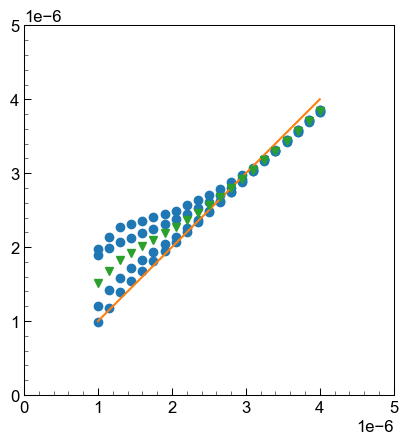

In [40]:
plt.plot(df_case["Tw_true"].values, df_case["Tw_est"], "o")
plt.plot(Tw_true_list, Tw_true_list)
plt.plot(Tw_true_list, TW_est_mean, "v")
plt.axis("square")
plt.xlim([0, 5e-6])
plt.ylim([0, 5e-6])

# Master plot

We plot 
1. Schematic of synthetic test
2. Case study of the recovery in the estimation of source parameter

In [41]:
masterSTF

{'t': array([-8.0000e-06, -7.9990e-06, -7.9980e-06, ...,  1.0595e-05,
         1.0596e-05,  1.0597e-05]),
 'STF': array([0., 0., 0., ..., 0., 0., 0.]),
 'STF_Qconvolved': array([471.52199332, 471.52428791, 471.52887721, ..., 471.52887721,
        471.52428791, 471.52199332]),
 'STF_Qdeconvolved': array([96571.22632395, 96576.82980563, 96582.45416368, ...,
        96526.6228575 , 96520.89491625, 96515.18808024]),
 'source_dist': 0.12,
 'M0_try': 0.5,
 'TR_try': 2.6e-06}

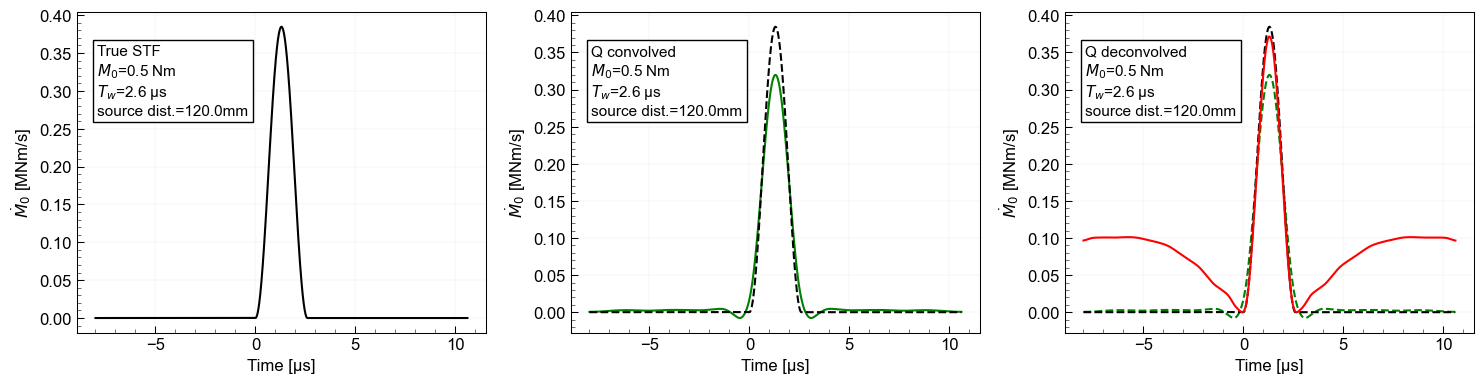

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(masterSTF["t"]*1e6, masterSTF["STF"]/1e6, "k-")


axs[1].plot(masterSTF["t"]*1e6, masterSTF["STF_Qconvolved"]/1e6, "g-", zorder=1)
axs[1].plot(masterSTF["t"]*1e6, masterSTF["STF"]/1e6, "k--", zorder=2)


axs[2].plot(masterSTF["t"]*1e6, masterSTF["STF"]/1e6, "k--", zorder=2)
axs[2].plot(masterSTF["t"]*1e6, masterSTF["STF_Qconvolved"]/1e6, "g--", zorder=1)
axs[2].plot(masterSTF["t"]*1e6, masterSTF["STF_Qdeconvolved"]/1e6, "r-", zorder=3)

titlestr = ["True STF", "Q convolved", "Q deconvolved"]
props = dict(boxstyle='square', facecolor='white', alpha=1.0)

for i, ax in enumerate(axs):
   
    annot_txt = '\n'.join((
        r'{}'.format(titlestr[i]),
        r'$M_0$={:.1f} Nm'.format(masterSTF["M0_try"]),
        r'$T_w$={:.1f} μs'.format(masterSTF["TR_try"]*1e6),
        r'source dist.={:.1f}mm'.format(masterSTF["source_dist"]*1e3)))
    
    ax.text(0.05, 0.9, annot_txt, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
                                 
    ax.set_xlabel("Time [μs]")
    ylabelstr = r"$\dot{M}_0$"
    ax.set_ylabel("{} [MNm/s]".format(ylabelstr))
    ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1, which="major")
    ax.set_axisbelow('True')

plt.tight_layout()

plt.savefig(f"../figure/synthetictest_STFestimation_schemcatic_sourcedist{masterSTF['source_dist']*1e3:.1f}mm.png", dpi=100)
plt.savefig(f"../figure/synthetictest_STFestimation_schemcatic_sourcedist{masterSTF['source_dist']*1e3:.1f}mm.eps")

In [43]:
df_case.head()

,source_dist,M0_true,Tw_true,M0_est,Tw_est,tshift_fit
0,0.09621,1.0,0.000001,0.912637,9.920772e-07,1.986333e-09
0,0.09621,1.0,0.000001,0.942789,1.172480e-06,-1.348893e-08
0,0.09621,1.0,0.000001,1.039438,1.393907e-06,-4.781545e-08
0,0.09621,1.0,0.000001,1.029815,1.539410e-06,-4.523029e-08
0,0.09621,1.0,0.000002,1.017506,1.676359e-06,-3.887789e-08


In [44]:
lc=plt.cm.viridis(np.linspace(0, 0.7, 4))    
lc

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.239346, 0.300855, 0.540844, 1.      ],
       [0.139147, 0.533812, 0.555298, 1.      ],
       [0.266941, 0.748751, 0.440573, 1.      ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


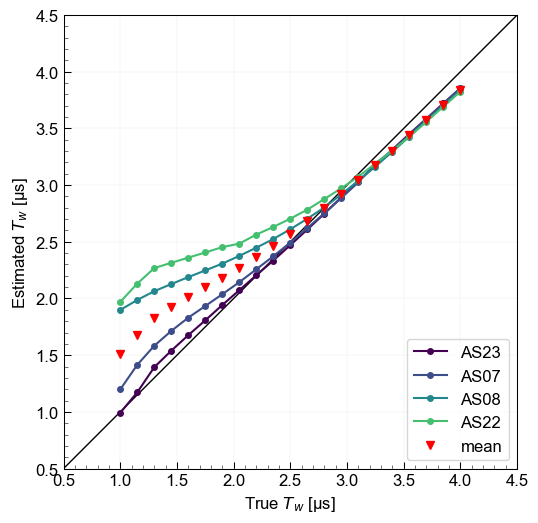

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.4))


for i, dist in enumerate(sourcedist_list):
    df_case_dist = df_case[df_case["source_dist"]==dist]
    ax.plot(df_case_dist["Tw_true"]*1e6, df_case_dist["Tw_est"]*1e6, "o-", c=lc[i, :],
            ms=4, label="AS{}".format(AEsensor_list[i][2:]))

# Plot mean
ax.plot(Tw_true_list*1e6, np.array(TW_est_mean)*1e6, "v", color="r", label="mean")

# plot true
xlimit = np.array([0.5, 4.5])
ax.plot(xlimit, xlimit, "k-", lw=1, zorder=1)

ax.axis("square")
ax.set_xlim(xlimit)
ax.set_ylim([0.5, 4.5])

ax.set_xlabel("True $T_w$ [μs]")
ax.set_ylabel("Estimated $T_w$ [μs]")
ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1, which="major")
ax.set_axisbelow('True')

ax.legend(loc=4)


plt.tight_layout()

plt.savefig(f"../figure/synthetictest_STFestimation_casestudy.png", dpi=100)
plt.savefig(f"../figure/synthetictest_STFestimation_casestudy.eps")

In [46]:
df_case

,source_dist,M0_true,Tw_true,M0_est,Tw_est,tshift_fit
0,0.096210,1.0,0.000001,0.912637,9.920772e-07,1.986333e-09
0,0.096210,1.0,0.000001,0.942789,1.172480e-06,-1.348893e-08
0,0.096210,1.0,0.000001,1.039438,1.393907e-06,-4.781545e-08
0,0.096210,1.0,0.000001,1.029815,1.539410e-06,-4.523029e-08
0,0.096210,1.0,0.000002,1.017506,1.676359e-06,-3.887789e-08
...,...,...,...,...,...,...
0,0.228358,1.0,0.000003,0.897925,3.305623e-06,4.416648e-08
0,0.228358,1.0,0.000004,0.882847,3.429388e-06,5.749445e-08
0,0.228358,1.0,0.000004,0.869673,3.559625e-06,6.756203e-08
0,0.228358,1.0,0.000004,0.856887,3.692637e-06,7.690526e-08


# Conclusion

We confirmed the deconvolution method can recovery the estimation of source duration around 2.6 μs, where the non-self-similarity has been observed. 